In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import math
import random
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import build_ground_state_circuit
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider, get_arcsin_x_rotation_provider
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [47]:
generator_layers = 1
discriminator_layers = 2
data_bus_size = 5

In [48]:
real_phase = False
generic_generator = True
all_layers_labeling = False

In [49]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(
    generator_layers, 
    discriminator_layers, 
    data_bus_size, 
    all_layers_labeling=all_layers_labeling,
    use_gen_label_qubit=False)

In [50]:
if not generic_generator:
    gen, gs = build_ground_state_circuit(qubits=data_qubits, full_parametrization=True)

In [51]:
if real_phase:
    real, real_symbols = build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols = build_x_rotation_state(qubits=data_qubits)

In [52]:
pure_gen = gen.copy()
gen.append([disc])

In [53]:
pure_real = real.copy()
real.append([disc])

In [54]:
print("REAL GROUND STATE")
pure_real

REAL GROUND STATE


(0, 2): ───Rx(r0)───

(0, 3): ───Rx(r1)───

(0, 4): ───Rx(r2)───

(0, 5): ───Rx(r3)───

(0, 6): ───Rx(r4)───

In [55]:
print("GENERATOR")
pure_gen

GENERATOR


(0, 2): ───Rx(l)───Rx(g0)───Rz(g5)───ZZ────────────────
                                     │
(0, 3): ───Rx(l)───Rx(g1)───Rz(g6)───ZZ^g10───ZZ───────
                                              │
(0, 4): ───Rx(l)───Rx(g2)───Rz(g7)───ZZ───────ZZ^g12───
                                     │
(0, 5): ───Rx(l)───Rx(g3)───Rz(g8)───ZZ^g11───ZZ───────
                                              │
(0, 6): ───Rx(l)───Rx(g4)───Rz(g9)────────────ZZ^g13───

In [56]:
print("DISCRIMINATOR")
disc

DISCRIMINATOR


(0, 0): ───Rx(l)───Rx(d0)───Rz(d7)─────────────ZZ────────────────Rx(d20)───Rz(d27)───ZZ────────────────
                                               │                                     │
(0, 1): ───Rx(l)───Rx(l)────Rx(d1)────Rz(d8)───ZZ^d14───ZZ───────Rx(d21)───Rz(d28)───ZZ^d34───ZZ───────
                                                        │                                     │
(0, 2): ───Rx(l)───Rx(d2)───Rz(d9)────ZZ────────────────ZZ^d17───Rx(d22)───Rz(d29)───ZZ───────ZZ^d37───
                                      │                                              │
(0, 3): ───Rx(l)───Rx(d3)───Rz(d10)───ZZ^d15───ZZ────────────────Rx(d23)───Rz(d30)───ZZ^d35───ZZ───────
                                               │                                              │
(0, 4): ───Rx(l)───Rx(d4)───Rz(d11)───ZZ───────ZZ^d18────────────Rx(d24)───Rz(d31)───ZZ───────ZZ^d38───
                                      │                                              │
(0, 5): ───Rx(l)───Rx(d5)───Rz(d12)───ZZ^d16───ZZ────────────────Rx(d25)───Rz(d32)───ZZ^d36───ZZ───────
                                               │                                              │
(0, 6): ───Rx(l)───Rx(d6)───Rz(d13)────────────ZZ^d19────────────Rx(d26)───Rz(d33)────────────ZZ^d39───

In [57]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [58]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [59]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [62]:
g_values = [0, 0.2]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})
x_rotations = get_arcsin_x_rotation_provider([0, 0.2], 5)

In [63]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  real, 
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = x_rotations,
                  use_analytical_expectation=True)

<Figure size 432x288 with 0 Axes>

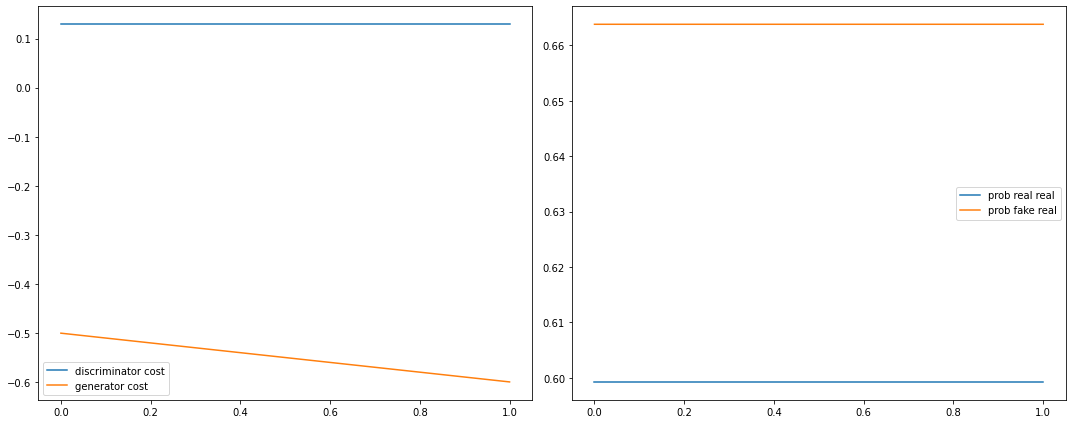

----------- AFTER GENERATOR TRAINING -----------
Epoch 0: generator cost = -0.5992749333381653
Epoch 0: discriminator cost = 0.12910646200180054
Prob(fake classified as real):  0.66382825
Prob(real classified as real):  0.59927493
-------------------------------------
----------- TRAINING DONE -----------
Weights: [
  {
    "gen_weights": [
      -0.3434864282608032,
      -0.3571421205997467,
      -0.3512559235095978,
      -0.33874592185020447,
      -0.3423677086830139,
      0.35110339522361755,
      -0.3516678810119629,
      0.3596133887767792,
      -0.3621758818626404,
      0.36498215794563293,
      -0.3596865236759186,
      -0.3466200828552246,
      0.007610377389937639,
      0.0012167501263320446
    ],
    "disc_weights": [
      -3.693887233734131,
      -3.852295160293579,
      -0.07091464102268219,
      -3.3218908309936523,
      -3.4208247661590576,
      -4.468804359436035,
      -2.606729030609131,
      -3.5510973930358887,
      -0.38165849447250366,
      0

In [64]:
epochs = 1
disc_iteration = 10
gen_iteration = 1
snapshot_interval_epochs = 10
results = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs)

In [186]:
def get_gen_for_g(g, gen_weights):
    rad = map_to_radians(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator, 
                                    gen_weights, 
                                    g, 
                                    size, 
                                    real_provider):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights))
    real = real_evaluator.get_state_from_params(real_provider(g))
    return generated, real, cirq.fidelity(generated, real)

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights), list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
    generated1 = gen_evaluator.get_state_from_params(get_gen_for_g(g1, gen_weights), list(range(size)))
    generated2 = gen_evaluator.get_state_from_params(get_gen_for_g(g2, gen_weights), list(range(size)))
    return generated1, generated2, cirq.fidelity(generated1, generated2)

In [214]:
ground1 = get_ground_state_for_g(-0.1, 5)
ground2 = get_ground_state_for_g(-0.0, 5)
ground3 = get_ground_state_for_g(-0.05, 5)
ground4 = (abs(ground1) + abs(ground2)) / 2
ground1, ground2, ground3, ground4, cirq.fidelity(ground1, ground2), cirq.fidelity(abs(ground3), ground4)



(array([-0.67404669,  0.06740467,  0.06740467,  0.06740467,  0.06740467,
        -0.00674047,  0.06740467,  0.06740467,  0.06740467, -0.00674047,
        -0.00674047, -0.00674047,  0.06740467, -0.00674047,  0.06740467,
         0.06740467,  0.06740467,  0.06740467, -0.00674047,  0.06740467,
        -0.00674047, -0.00674047, -0.00674047,  0.06740467,  0.06740467,
         0.06740467, -0.00674047,  0.06740467,  0.06740467,  0.06740467,
         0.06740467, -0.67404669]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.69841965, -0.03492098, -0.03492098, -0.03492098, -0.03492098,
         0.00174605, -0.03492098, -0.03492098, -0.03492098,  0.00174605,
         0.00174605,  0.00174605, -0.03492098,  0.00174605, -0.03492098,
        -0.03492098, -0.03492098, -0.03492098,  0.00174605, -0.03492098,
         0.00174605,  0.00174605,  0.00174605, -0.03492098, -0.03492098,
        -0.0349

In [194]:
trained_disc_weights = tf.Variable(np.array([ 1.25888796e+01,  1.10409822e+01,  1.27487049e+01,  1.32927475e+01,
       -3.20522385e+01,  2.98508596e+00, -7.54223883e-01,  8.97036648e+00,
        8.98472309e+00, -2.77423954e+00,  8.90891266e+00,  5.72837019e+00,
        6.03105211e+00, -4.64482594e+00, -1.10843427e-01,  7.78598115e-02,
        3.00343895e+00,  3.83781940e-01,  6.08641243e+00,  8.64131927e+00,
       -2.17593918e+01,  1.45857897e+01,  2.36893883e+01,  8.75363445e+00,
       -2.42768993e+01,  1.27688437e+01,  2.53628349e+00,  1.39768391e+01,
        1.40961084e+01, -2.04474068e+01,  4.71392822e+00,  1.66926212e+01,
        1.88311214e+01,  9.17525005e+00,  1.16109962e+01,  1.08004580e+01,
        1.10795708e+01,  5.81477690e+00, -5.50215101e+00,  2.22007637e+01,
        2.25015125e+01,  3.21826210e+01, -1.80058708e+01, -7.85126591e+00,
       -7.77073908e+00,  1.40237570e+01,  3.14071465e+01, -1.07477732e+01,
        1.55852342e+00,  2.63786411e+01,  1.31890945e+01,  7.14759350e+00,
        5.46145630e+00, -1.79730053e+01,  7.40563774e+00,  1.06135674e+01,
       -1.55095673e+00, -2.66580944e+01,  6.51995277e+00, -2.37151980e+00,
        3.51896515e+01,  1.50027342e+01,  1.80733763e-02, -1.75052185e+01,
        9.60706902e+00, -6.06413984e+00,  5.35433817e+00, -7.88707399e+00,
        1.27363043e+01,  1.02446747e+01]), dtype=tf.float32)

trained_gen_weights = np.array([
      -4.649629592895508,
      3.101015567779541,
      -3.111968994140625,
      0.718622088432312,
      -3.10376238822937,
      -7.195709705352783,
      2.241804361343384,
      4.495307445526123,
      -9.874565124511719,
      -4.100712299346924,
      -13.755752563476562,
      -2.117293119430542,
      0.5071558952331543,
      10.275369644165039,
      -4.674619197845459,
      3.184067487716675,
      7.742251396179199,
      -2.084336519241333,
      0.015724116936326027,
      11.065336227416992,
      -7.059167385101318,
      1.1897140741348267,
      -4.934125900268555,
      -6.739679336547852,
      -3.538717031478882,
      0.5198691487312317,
      1.4716018438339233,
      4.639389514923096,
      11.032812118530273,
      3.159381151199341,
      -6.2087297439575195,
      7.79973030090332,
      -5.470395088195801,
      5.8658013343811035,
      -4.232997894287109,
      1.988687515258789,
      -3.0304601192474365,
      -10.554874420166016,
      3.671308755874634,
      -3.4935901165008545,
      -1.502490758895874,
      -1.7941570281982422
    ])

gen_symbols = gs + (ls,)
# gen_symbols = gs
# real_symbols = ('r0', 'r1', 'r2')

In [195]:
gen_evaluator = CircuitEvaluator(pure_gen, gen_symbols)
real_evaluator = CircuitEvaluator(pure_real, real_symbols)

In [200]:
g = -0.1
get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size, get_g_parameters_provider())

(array([-0.37731087-0.0811675j , -0.18085268+0.23092014j,
        -0.03165285-0.2447768j ,  0.24665835-0.16773075j,
         0.00445655-0.00593627j, -0.06302135+0.04205354j,
        -0.05793424+0.06867249j,  0.0202412 -0.01197964j,
         0.00216764-0.00115121j, -0.00421622-0.0010907j ,
         0.0040171 -0.00045099j,  0.00407331-0.00259159j,
        -0.01176773-0.00377527j,  0.0185207 -0.00606403j,
         0.01976581+0.01429253j, -0.0028115 -0.01514306j,
         0.00329002+0.04349204j,  0.03145908+0.01166302j,
        -0.02582761+0.01177412j, -0.026391  -0.02014987j,
        -0.0030469 -0.00035139j,  0.00946684+0.00332172j,
         0.01341757+0.00545324j, -0.0032125 -0.00429461j,
        -0.0760088 +0.00385869j,  0.04631899-0.00272392j,
        -0.05619271+0.01163532j, -0.00219731+0.08335549j,
         0.25464985-0.0469288j , -0.264992  +0.29769003j,
        -0.49087024-0.07282259j,  0.19975169+0.25249168j], dtype=complex64),
 array([ 0.184799  +0.j,  0.58438575+0.j,  0.18479902

In [190]:
g = -1
get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size, get_g_parameters_provider())

(array([-0.02435654-0.1902056j , -0.19515288-0.11648373j,
         0.08345419-0.1903887j , -0.18535236-0.08096562j,
         0.11612582+0.04735206j, -0.06836013+0.19240332j,
         0.14600399-0.11264499j, -0.00122743+0.13270715j,
         0.00031277+0.1505127j ,  0.16298561+0.11961195j,
        -0.08987801+0.16151407j,  0.13619669+0.08167708j,
         0.11782363+0.02000505j,  0.01544211+0.19913372j,
         0.08575617-0.15900977j,  0.02598283+0.12305039j,
         0.05198056+0.16467279j,  0.1923159 +0.07155653j,
        -0.04311047+0.18240288j,  0.17686254+0.04210223j,
        -0.10968473-0.02181027j,  0.03130385-0.17920177j,
        -0.11122639+0.12064118j, -0.02152339-0.11628234j,
        -0.01267695+0.19866441j,  0.17221147+0.14199674j,
        -0.10956728+0.17222396j,  0.17286973+0.11913121j,
         0.12042966+0.01432219j, -0.03035793+0.17915641j,
         0.11047583-0.12090723j,  0.03273152+0.12426975j], dtype=complex64),
 array([ 0.1767766 +0.j,  0.1767766 +0.j,  0.1767766 

In [ ]:
compare_generated_for_g(gen_evaluator, -0.9, -0.8, trained_gen_weights, data_bus_size)

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)